In [77]:
import re
import requests
import pickle
import spacy
from urllib.request import urlopen
from bs4 import BeautifulSoup
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from wordcloud import WordCloud
from nltk.lm.preprocessing import pad_both_ends, padded_everygram_pipeline
from nltk import word_tokenize, sent_tokenize
from nltk.lm import KneserNeyInterpolated, MLE

In [3]:
response=requests.get(url="https://en.wikipedia.org/wiki/Non-fungible_token")
soup = BeautifulSoup(response.content, 'html.parser')
soup_element=soup.find(id="mw-panel")
type(soup_element)
soup_element.find_next('li')

<li class="mw-list-item" id="n-mainpage-description"><a accesskey="z" href="/wiki/Main_Page" icon="home" title="Visit the main page [z]"><span>Main page</span></a></li>

In [16]:
RC_FINDENTRY = re.compile(r"(?=^/wiki/)([^:#=<>]*?)")

cache_dict = set()
entry = '/wiki/Non-fungible_token'

wikiArrayWithLineBreaks = []
wikiArray = []

def scrapeWiki(arraySave, entry, depth=1):
    if entry not in cache_dict:
        cache_dict.add(entry)
    else:
        return
    response = requests.get("https://en.wikipedia.org/" + entry, allow_redirects=False)
    soup = BeautifulSoup(response.content, 'html.parser')
    content_body = soup.find('div', {
        "id": "bodyContent"
    })
    arraySave.append(content_body.text)
    if depth <= 0:
        return
    content_lists = content_body.find_all("a", attrs={'href': RC_FINDENTRY})
    redirect_to_remove = soup.find_all('a', attrs={'class': 'mw-redirect'})
    content_lists_url = map(lambda x: x.attrs['href'], content_lists)
    redirect_to_remove_url = map(lambda x: x.attrs['href'], redirect_to_remove)
    remains = set(content_lists_url) - set(redirect_to_remove_url)
    for next_entry in remains:
        if next_entry not in cache_dict:
            scrapeWiki(arraySave, next_entry, depth - 1)
            
scrapeWiki(wikiArrayWithLineBreaks, entry, 1)

for article in wikiArrayWithLineBreaks:
    wikiArray.append(article.replace("\n", ""))
            
a_file = open("wikiNFTData.pkl", "wb")
with a_file as f:
    pickle.dump(wikiArray, f)

In [58]:
pipe = spacy.load('en_core_web_sm')
nonStopWords = {}
all_stopwords = pipe.Defaults.stop_words
for article in wikiArray:
    text = pipe(article)
    for token in text:
        if token.lemma_ not in all_stopwords:
            nonStopWords[token.lemma_] = nonStopWords.get(token.lemma_, 0) + 1

In [89]:
temp = Counter(nonStopWords)
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~–'''
high = temp.most_common(50)
topWords = {}
for word in high:
    if word[0] not in punc:
        if len(topWords) < 20:
            topWords[word[0]] = word[1]
print(list(topWords))

['output', 'parser', 'retrieve', '.navbox', '\xa0', 'original', 'archive', 'use', '.cs1', 'style', 'lock', '.reflist', '2021', '.navbar', 'January', 'May', '2018', 'October', 'March', '.mw']


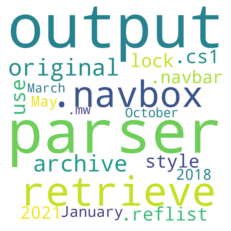

In [44]:
wc = WordCloud(background_color="white",width=1000,height=1000, relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(topWords)
#plt.imshow(wc)

# Create and generate a word cloud image:
#wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [59]:
with open('nftData.pkl', 'rb') as f:
    train = pickle.load(f)
test = train[8000:]
train = train[:8000]

allSents = []
for tweet in test:
    noLineBreakTweet = tweet.replace("\n","")
    for sent in pipe(noLineBreakTweet).sents:
        allSents.append(sent.text)

nonStopWordsNFT = {}
all_stopwords = pipe.Defaults.stop_words
for sent in allSents:
    text = pipe(sent)
    for token in text:
        if token.lemma_ not in all_stopwords:
            nonStopWordsNFT[token.lemma_] = nonStopWordsNFT.get(token.lemma_, 0) + 1

wordTypesNotVocab = []
for word in nonStopWordsNFT:
    if word not in nonStopWords:
        wordTypesNotVocab.append(word)

In [60]:
print(len(wordTypesNotVocab)/len(nonStopWords))

0.028774971007036788


In [61]:
nonStopWordTokens = {}
for article in wikiArray:
    text = pipe(article)
    for token in text:
        if token.lemma_ not in all_stopwords:
            nonStopWordTokens[token] = nonStopWordTokens.get(token, 0) + 1

nonStopWordTokensNFT = {}
all_stopwords = pipe.Defaults.stop_words
for sent in allSents:
    text = pipe(sent)
    for token in text:
        if token.lemma_ not in all_stopwords:
            nonStopWordTokensNFT[token] = nonStopWordTokensNFT.get(token, 0) + 1
            
wordTokensNotVocab = []
for word in nonStopWordTokensNFT:
    if word not in nonStopWordTokens:
        wordTokensNotVocab.append(word)


In [62]:
print(len(wordTokensNotVocab)/len(nonStopWordTokens))

0.01853340190410037


In [63]:
allTrainSents = []
for tweet in train:
    noLineBreakTweet = tweet.replace("\n","")
    for sent in pipe(noLineBreakTweet).sents:
        allTrainSents.append(sent.text)
        
nonStopWordTokensNFT_TrainSet = {}
all_stopwords = pipe.Defaults.stop_words
for sent in allTrainSents:
    text = pipe(sent)
    for token in text:
        if token.lemma_ not in all_stopwords:
            nonStopWordTokensNFT_TrainSet[token] = nonStopWordTokensNFT_TrainSet.get(token, 0) + 1
            
wordTokensNotVocab_JustTweets = []
for word in nonStopWordTokensNFT:
    if word not in nonStopWordTokens:
        wordTokensNotVocab_JustTweets.append(word)

In [64]:
print(len(wordTokensNotVocab)/len(nonStopWordTokensNFT_TrainSet))

0.14028524404150025


In [65]:
wikiSents = []
for article in wikiArray:
    for sent in pipe(article).sents:
        wikiSents.append(sent.text)

In [82]:
wikiSentsFirst9000 = wikiSents[:9000]

In [83]:
sentenceTokens = []
for sentence in wikiSentsFirst9000:
    sentenceTokens.append(list(pad_both_ends(word_tokenize(sentence.lower()), n=3)))

In [84]:
train_data, vocab = padded_everygram_pipeline(3, sentenceTokens)
model = KneserNeyInterpolated(3)
model.fit(train_data, vocab)

In [87]:
totalPerpScore = 0
for sent in allSents:
    totalPerpScore += model.perplexity(sent)
print(totalPerpScore/len(wikiSentsFirst9000))

4584.561111111103
